<a href="https://colab.research.google.com/github/kjsp91/Multimodal-Cyberbullying-Detection/blob/master/Final_XLM%2BBIGRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Final Roberta XLM 64.78**

In [ ]:
# Install necessary libraries
# !pip install torch transformers scikit-learn tqdm nltk matplotlib seaborn

import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import XLMRobertaTokenizer, XLMRobertaModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns




# Load dataset
df = pd.read_csv('/content/cyberbullying dataset new.csv', encoding='latin-1')

# Drop unnecessary columns
df.drop(['Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
         'Unnamed: 10', 'Unnamed: 11', 'Img_Name', 'Img_Label', 'Text_Label'], axis=1, inplace=True)



# Drop duplicates and handle missing values
df.dropna(axis=0, inplace=True)
df.drop_duplicates(inplace=True)

# Encode labels
label_encoder = LabelEncoder()
df['Img_Text_Label'] = label_encoder.fit_transform(df['Img_Text_Label'])

# Initialize tokenizer for XLM-R
tokenizer_xlm = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

# Tokenize texts for XLM-R
encoded_texts_xlm = tokenizer_xlm(df['Img_Text'].tolist(),
                                  padding=True, truncation=True,
                                  max_length=50, return_tensors='pt')
input_ids_xlm = encoded_texts_xlm['input_ids']
attention_mask_xlm = encoded_texts_xlm['attention_mask']

# Convert labels to tensor
labels = torch.tensor(df['Img_Text_Label'].values)

# Train-test split
train_inputs_xlm, val_inputs_xlm, train_labels, val_labels = train_test_split(input_ids_xlm, labels, test_size=0.2, random_state=42)
train_masks_xlm, val_masks_xlm, _, _ = train_test_split(attention_mask_xlm, labels, test_size=0.2, random_state=42)

# Define DataLoader
class CustomDataset(Dataset):
    def __init__(self, input_ids_xlm, attention_mask_xlm, labels):
        self.input_ids_xlm = input_ids_xlm
        self.attention_mask_xlm = attention_mask_xlm
        self.labels = labels

    def __len__(self):
        return len(self.input_ids_xlm)

    def __getitem__(self, idx):
        return (self.input_ids_xlm[idx], self.attention_mask_xlm[idx], self.labels[idx])

train_dataset = CustomDataset(train_inputs_xlm, train_masks_xlm, train_labels)
val_dataset = CustomDataset(val_inputs_xlm, val_masks_xlm, val_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Define model architecture
class CustomXLMGRUTransformer(nn.Module):
    def __init__(self, hidden_size=512, num_labels=2, dropout_rate=0.5):
        super(CustomXLMGRUTransformer, self).__init__()
        self.xlm_roberta = XLMRobertaModel.from_pretrained('xlm-roberta-base')

        # BiGRU layer
        self.gru = nn.GRU(input_size=768, hidden_size=hidden_size, batch_first=True, bidirectional=True)

        # Transformer layer
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=hidden_size * 2, nhead=8)

        # Batch normalization
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids_xlm, attention_mask_xlm):
        # XLM-R embeddings
        xlm_outputs = self.xlm_roberta(input_ids_xlm, attention_mask=attention_mask_xlm)
        sequence_output = xlm_outputs.last_hidden_state  # shape: (batch_size, 50, 768)

        # BiGRU
        gru_outputs, _ = self.gru(sequence_output)  # shape: (batch_size, 50, 1024)

        # Transformer
        transformer_output = self.transformer_layer(gru_outputs)  # shape: (batch_size, 50, 1024)

        # Pooling
        pooled_output = torch.mean(transformer_output, dim=1)  # shape: (batch_size, 1024)

        # Batch normalization
        normalized_output = self.batch_norm(pooled_output)

        # Fully connected layers
        combined = self.dropout(normalized_output)
        combined = torch.relu(self.fc1(combined))
        logits = self.fc2(combined)

        return logits

# Initialize the model
model = CustomXLMGRUTransformer()

# Print model architecture
# print(model)

# Define optimizer with weight decay
optimizer = AdamW(model.parameters(), lr=1e-5, eps=1e-8, weight_decay=0.01)

# Scheduler for learning rate
total_steps = len(train_loader) * 5  # 5 epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Training loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 45
best_accuracy = 0

for epoch in range(epochs):
    # Training
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}'):
        input_ids_xlm, attention_mask_xlm, labels = batch
        input_ids_xlm, attention_mask_xlm, labels = input_ids_xlm.to(device), attention_mask_xlm.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids_xlm, attention_mask_xlm)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_loss += loss.item()

    # Validation
    model.eval()
    val_loss = 0
    val_predictions, val_true_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids_xlm, attention_mask_xlm, labels = batch
            input_ids_xlm, attention_mask_xlm, labels = input_ids_xlm.to(device), attention_mask_xlm.to(device), labels.to(device)

            outputs = model(input_ids_xlm, attention_mask_xlm)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            val_predictions.extend(preds.cpu().numpy())
            val_true_labels.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_true_labels, val_predictions)
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model, '/content/drive/MyDrive/final_xlm_bigru2.pth')

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss / len(train_loader):.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

# Print the best accuracy after all epochs
print(f"Best Validation Accuracy: {best_accuracy:.4f}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1/45: 100%|██████████| 288/288 [01:15<00:00,  3.83it/s]


Epoch 1, Train Loss: 0.6813, Val Loss: 0.6566, Val Accuracy: 0.6148


Epoch 2/45: 100%|██████████| 288/288 [01:14<00:00,  3.87it/s]


Epoch 2, Train Loss: 0.6222, Val Loss: 0.6442, Val Accuracy: 0.6426


Epoch 3/45: 100%|██████████| 288/288 [01:14<00:00,  3.86it/s]


Epoch 3, Train Loss: 0.5761, Val Loss: 0.6400, Val Accuracy: 0.6461


Epoch 4/45: 100%|██████████| 288/288 [01:14<00:00,  3.87it/s]


Epoch 4, Train Loss: 0.5359, Val Loss: 0.6585, Val Accuracy: 0.6496


Epoch 5/45: 100%|██████████| 288/288 [01:14<00:00,  3.87it/s]


Epoch 5, Train Loss: 0.4937, Val Loss: 0.6638, Val Accuracy: 0.6487


Epoch 6/45: 100%|██████████| 288/288 [01:14<00:00,  3.89it/s]


Epoch 6, Train Loss: 0.4828, Val Loss: 0.6658, Val Accuracy: 0.6487


Epoch 7/45: 100%|██████████| 288/288 [01:13<00:00,  3.91it/s]


Epoch 7, Train Loss: 0.4728, Val Loss: 0.6593, Val Accuracy: 0.6530


Epoch 8/45: 100%|██████████| 288/288 [01:14<00:00,  3.87it/s]


Epoch 8, Train Loss: 0.4775, Val Loss: 0.6688, Val Accuracy: 0.6461


Epoch 9/45: 100%|██████████| 288/288 [01:14<00:00,  3.89it/s]


Epoch 9, Train Loss: 0.4760, Val Loss: 0.6621, Val Accuracy: 0.6470


Epoch 10/45: 100%|██████████| 288/288 [01:13<00:00,  3.89it/s]


Epoch 10, Train Loss: 0.4785, Val Loss: 0.6687, Val Accuracy: 0.6539


Epoch 11/45: 100%|██████████| 288/288 [01:15<00:00,  3.84it/s]


Epoch 11, Train Loss: 0.4731, Val Loss: 0.6663, Val Accuracy: 0.6496


Epoch 12/45: 100%|██████████| 288/288 [01:14<00:00,  3.89it/s]


Epoch 12, Train Loss: 0.4814, Val Loss: 0.6629, Val Accuracy: 0.6513


Epoch 13/45: 100%|██████████| 288/288 [01:14<00:00,  3.89it/s]


Epoch 13, Train Loss: 0.4822, Val Loss: 0.6581, Val Accuracy: 0.6504


Epoch 14/45: 100%|██████████| 288/288 [01:13<00:00,  3.90it/s]


Epoch 14, Train Loss: 0.4730, Val Loss: 0.6601, Val Accuracy: 0.6461


Epoch 15/45: 100%|██████████| 288/288 [01:13<00:00,  3.90it/s]


Epoch 15, Train Loss: 0.4842, Val Loss: 0.6509, Val Accuracy: 0.6487


Epoch 16/45: 100%|██████████| 288/288 [01:14<00:00,  3.86it/s]


Epoch 16, Train Loss: 0.4738, Val Loss: 0.6625, Val Accuracy: 0.6513


Epoch 17/45: 100%|██████████| 288/288 [01:14<00:00,  3.88it/s]


Epoch 17, Train Loss: 0.4766, Val Loss: 0.6610, Val Accuracy: 0.6504


Epoch 18/45: 100%|██████████| 288/288 [01:13<00:00,  3.90it/s]


Epoch 18, Train Loss: 0.4823, Val Loss: 0.6590, Val Accuracy: 0.6461


Epoch 19/45: 100%|██████████| 288/288 [01:14<00:00,  3.89it/s]


Epoch 19, Train Loss: 0.4773, Val Loss: 0.6634, Val Accuracy: 0.6487


Epoch 20/45: 100%|██████████| 288/288 [01:14<00:00,  3.89it/s]


Epoch 20, Train Loss: 0.4910, Val Loss: 0.6587, Val Accuracy: 0.6470


Epoch 21/45: 100%|██████████| 288/288 [01:13<00:00,  3.89it/s]


Epoch 21, Train Loss: 0.4786, Val Loss: 0.6596, Val Accuracy: 0.6478


Epoch 22/45: 100%|██████████| 288/288 [01:13<00:00,  3.90it/s]


Epoch 22, Train Loss: 0.4738, Val Loss: 0.6634, Val Accuracy: 0.6496


Epoch 23/45: 100%|██████████| 288/288 [01:13<00:00,  3.89it/s]


Epoch 23, Train Loss: 0.4842, Val Loss: 0.6586, Val Accuracy: 0.6470


Epoch 24/45: 100%|██████████| 288/288 [01:13<00:00,  3.89it/s]


Epoch 24, Train Loss: 0.4722, Val Loss: 0.6629, Val Accuracy: 0.6513


Epoch 25/45: 100%|██████████| 288/288 [01:13<00:00,  3.89it/s]


Epoch 25, Train Loss: 0.4821, Val Loss: 0.6592, Val Accuracy: 0.6452


Epoch 26/45: 100%|██████████| 288/288 [01:13<00:00,  3.91it/s]


Epoch 26, Train Loss: 0.4749, Val Loss: 0.6598, Val Accuracy: 0.6504


Epoch 27/45: 100%|██████████| 288/288 [01:14<00:00,  3.89it/s]


Epoch 27, Train Loss: 0.4764, Val Loss: 0.6658, Val Accuracy: 0.6522


Epoch 28/45: 100%|██████████| 288/288 [01:13<00:00,  3.90it/s]


Epoch 28, Train Loss: 0.4795, Val Loss: 0.6628, Val Accuracy: 0.6478


Epoch 29/45: 100%|██████████| 288/288 [01:13<00:00,  3.90it/s]


Epoch 29, Train Loss: 0.4780, Val Loss: 0.6604, Val Accuracy: 0.6443


Epoch 30/45: 100%|██████████| 288/288 [01:13<00:00,  3.90it/s]


Epoch 30, Train Loss: 0.4785, Val Loss: 0.6609, Val Accuracy: 0.6504


Epoch 31/45: 100%|██████████| 288/288 [01:13<00:00,  3.89it/s]


Epoch 31, Train Loss: 0.4752, Val Loss: 0.6711, Val Accuracy: 0.6504


Epoch 32/45: 100%|██████████| 288/288 [01:14<00:00,  3.89it/s]


Epoch 32, Train Loss: 0.4782, Val Loss: 0.6590, Val Accuracy: 0.6496


Epoch 33/45: 100%|██████████| 288/288 [01:13<00:00,  3.89it/s]


Epoch 33, Train Loss: 0.4847, Val Loss: 0.6596, Val Accuracy: 0.6539


Epoch 34/45: 100%|██████████| 288/288 [01:13<00:00,  3.90it/s]


Epoch 34, Train Loss: 0.4891, Val Loss: 0.6542, Val Accuracy: 0.6461


Epoch 35/45: 100%|██████████| 288/288 [01:13<00:00,  3.89it/s]


Epoch 35, Train Loss: 0.4759, Val Loss: 0.6612, Val Accuracy: 0.6496


Epoch 36/45: 100%|██████████| 288/288 [01:14<00:00,  3.89it/s]


Epoch 36, Train Loss: 0.4799, Val Loss: 0.6653, Val Accuracy: 0.6470


Epoch 37/45: 100%|██████████| 288/288 [01:14<00:00,  3.89it/s]


Epoch 37, Train Loss: 0.4794, Val Loss: 0.6609, Val Accuracy: 0.6504


Epoch 38/45: 100%|██████████| 288/288 [01:14<00:00,  3.89it/s]


Epoch 38, Train Loss: 0.4774, Val Loss: 0.6664, Val Accuracy: 0.6522


Epoch 39/45: 100%|██████████| 288/288 [01:14<00:00,  3.89it/s]


Epoch 39, Train Loss: 0.4789, Val Loss: 0.6607, Val Accuracy: 0.6496


Epoch 40/45: 100%|██████████| 288/288 [01:13<00:00,  3.89it/s]


Epoch 40, Train Loss: 0.4793, Val Loss: 0.6639, Val Accuracy: 0.6461


Epoch 41/45: 100%|██████████| 288/288 [01:14<00:00,  3.89it/s]


Epoch 41, Train Loss: 0.4739, Val Loss: 0.6603, Val Accuracy: 0.6452


Epoch 42/45: 100%|██████████| 288/288 [01:14<00:00,  3.87it/s]


Epoch 42, Train Loss: 0.4801, Val Loss: 0.6606, Val Accuracy: 0.6513


Epoch 43/45: 100%|██████████| 288/288 [01:13<00:00,  3.89it/s]


Epoch 43, Train Loss: 0.4762, Val Loss: 0.6577, Val Accuracy: 0.6522


Epoch 44/45: 100%|██████████| 288/288 [01:13<00:00,  3.89it/s]


Epoch 44, Train Loss: 0.4794, Val Loss: 0.6544, Val Accuracy: 0.6487


Epoch 45/45: 100%|██████████| 288/288 [01:14<00:00,  3.89it/s]


Epoch 45, Train Loss: 0.4830, Val Loss: 0.6567, Val Accuracy: 0.6548
Best Validation Accuracy: 0.6548


# **Accuracy**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import XLMRobertaTokenizer

# Load dataset
df = pd.read_csv('/content/cyberbullying dataset new.csv', encoding='latin-1')

# Drop unnecessary columns
df.drop(['Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
         'Unnamed: 10', 'Unnamed: 11', 'Img_Name', 'Img_Label', 'Text_Label'], axis=1, inplace=True)

# Drop duplicates and handle missing values
df.dropna(axis=0, inplace=True)
df.drop_duplicates(inplace=True)

# Encode labels
label_encoder = LabelEncoder()
df['Img_Text_Label'] = label_encoder.fit_transform(df['Img_Text_Label'])

# Initialize tokenizer for XLM-R
tokenizer_xlm = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

# Tokenize texts for XLM-R
encoded_texts_xlm = tokenizer_xlm(df['Img_Text'].tolist(),
                                  padding=True, truncation=True,
                                  max_length=50, return_tensors='pt')
input_ids_xlm = encoded_texts_xlm['input_ids']
attention_mask_xlm = encoded_texts_xlm['attention_mask']

# Convert labels to tensor
labels = torch.tensor(df['Img_Text_Label'].values)

# Train-test split
_, val_inputs_xlm, _, val_labels = train_test_split(input_ids_xlm, labels, test_size=0.2, random_state=42)
_, val_masks_xlm, _, _ = train_test_split(attention_mask_xlm, labels, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

In [ ]:
# Define validation dataset
class CustomDataset(Dataset):
    def __init__(self, input_ids_xlm, attention_mask_xlm, labels):
        self.input_ids_xlm = input_ids_xlm
        self.attention_mask_xlm = attention_mask_xlm
        self.labels = labels

    def __len__(self):
        return len(self.input_ids_xlm)

    def __getitem__(self, idx):
        return (self.input_ids_xlm[idx], self.attention_mask_xlm[idx], self.labels[idx])

val_dataset = CustomDataset(val_inputs_xlm, val_masks_xlm, val_labels)

# Create DataLoader for validation data
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)


In [ ]:
import torch
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
from transformers import XLMRobertaTokenizer, XLMRobertaModel


# Define the CustomXLMGRUTransformer class here (copied from previous cell):
class CustomXLMGRUTransformer(nn.Module):
    def __init__(self, hidden_size=512, num_labels=2, dropout_rate=0.5):
        super(CustomXLMGRUTransformer, self).__init__()
        self.xlm_roberta = XLMRobertaModel.from_pretrained('xlm-roberta-base')

        # BiGRU layer
        self.gru = nn.GRU(input_size=768, hidden_size=hidden_size, batch_first=True, bidirectional=True)

        # Transformer layer
        self.transformer_layer = nn.TransformerEncoderLayer(d_model=hidden_size * 2, nhead=8)

        # Batch normalization
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_labels)

    def forward(self, input_ids_xlm, attention_mask_xlm):
        # XLM-R embeddings
        xlm_outputs = self.xlm_roberta(input_ids_xlm, attention_mask=attention_mask_xlm)
        sequence_output = xlm_outputs.last_hidden_state  # shape: (batch_size, 50, 768)

        # BiGRU
        gru_outputs, _ = self.gru(sequence_output)  # shape: (batch_size, 50, 1024)

        # Transformer
        transformer_output = self.transformer_layer(gru_outputs)  # shape: (batch_size, 50, 1024)

        # Pooling
        pooled_output = torch.mean(transformer_output, dim=1)  # shape: (batch_size, 1024)

        # Batch normalization
        normalized_output = self.batch_norm(pooled_output)

        # Fully connected layers
        combined = self.dropout(normalized_output)
        combined = torch.relu(self.fc1(combined))
        logits = self.fc2(combined)

        return logits



<ipython-input-4-95bc36fdc50b>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('/content/drive/MyDrive/FINAL XLM.pth')


Validation Accuracy: 0.6487


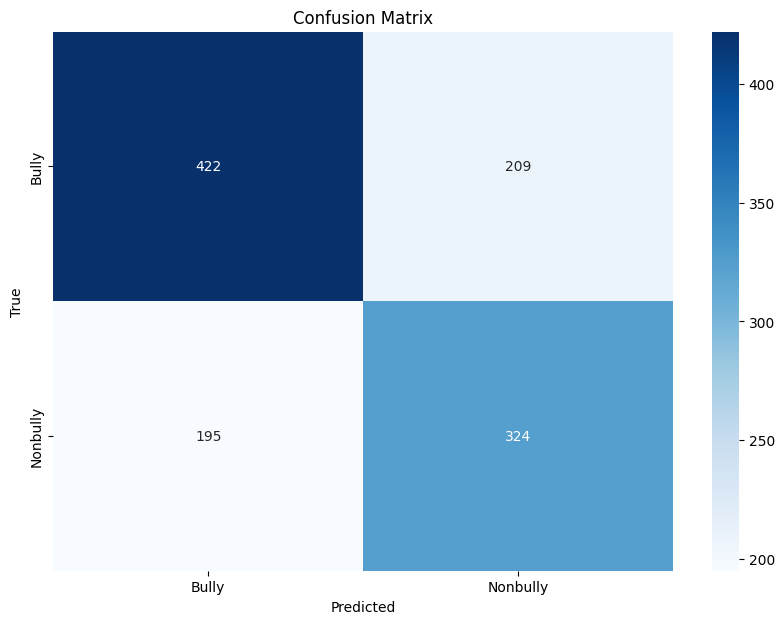

In [ ]:
import torch
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the saved model
model = torch.load('/content/drive/MyDrive/FINAL XLM.pth')
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Evaluate on validation set
val_predictions, val_true_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        input_ids_xlm, attention_mask_xlm, labels = batch
        input_ids_xlm, attention_mask_xlm, labels = input_ids_xlm.to(device), attention_mask_xlm.to(device), labels.to(device)

        outputs = model(input_ids_xlm, attention_mask_xlm)
        preds = torch.argmax(outputs, dim=1)
        val_predictions.extend(preds.cpu().numpy())
        val_true_labels.extend(labels.cpu().numpy())

# Compute metrics
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy = accuracy_score(val_true_labels, val_predictions)
conf_mat = confusion_matrix(val_true_labels, val_predictions)

print(f"Validation Accuracy: {accuracy:.4f}")

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Validation Accuracy: 0.6487

Classification Report:
              precision    recall  f1-score   support

       Bully       0.68      0.67      0.68       631
    Nonbully       0.61      0.62      0.62       519

    accuracy                           0.65      1150
   macro avg       0.65      0.65      0.65      1150
weighted avg       0.65      0.65      0.65      1150



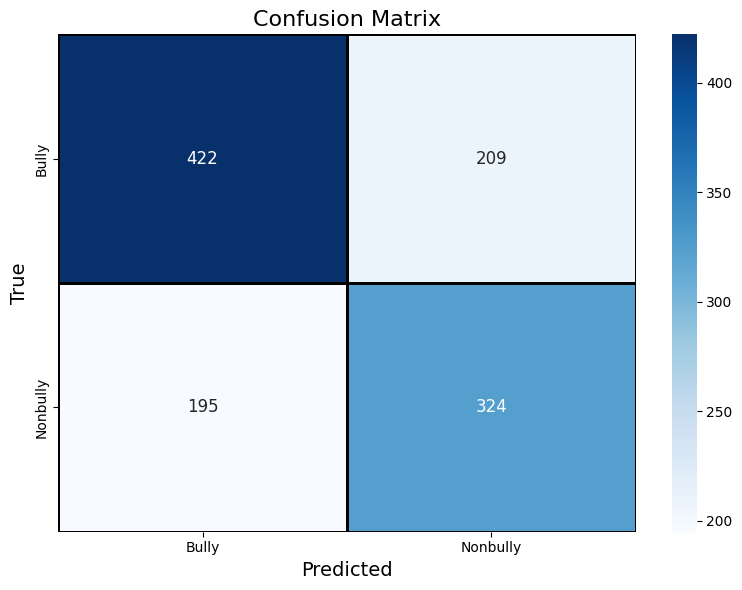

In [ ]:
# Print accuracy and classification report
print(f"Validation Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(val_true_labels, val_predictions, target_names=label_encoder.classes_))

# Plot confusion matrix with borders and larger font size inside the cells
plt.figure(figsize=(8, 6))

# Create heatmap with borders around the cells and larger numbers inside the cells
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_, linewidths=1, linecolor='black',_
            annot_kws={"size": 12})  # Increase the number size inside the boxes

# Adding title and labels
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)

plt.tight_layout()
plt.show()


# **Prediction**

In [ ]:
import torch
from transformers import XLMRobertaTokenizer

# Load the model
model_path = '/content/drive/MyDrive/final_xlm_bigru2.pth'
model = torch.load(model_path, map_location=torch.device('cpu'))
model.eval()

# Load the tokenizer
tokenizer_xlm = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

# Define a function for preprocessing and prediction
def predict(text):
    # Preprocess the text
    encoded_text = tokenizer_xlm(
        text,
        padding=True,
        truncation=True,
        max_length=50,
        return_tensors='pt'
    )

    input_ids = encoded_text['input_ids']
    attention_mask = encoded_text['attention_mask']

    # Run the model to get predictions
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        predictions = torch.argmax(outputs, dim=1).item()

    return predictions

# Test the function
sample_text = "This is a test input to check the model's prediction."
prediction = predict(sample_text)

# Print the result
print(f"Prediction for the input: {prediction}")


<ipython-input-7-4444480f14f9>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(model_path, map_location=torch.device('cpu'))


Prediction for the input: 1


In [ ]:
!pip show transformers


Name: transformers
Version: 4.47.1
Summary: State-of-the-art Machine Learning for JAX, PyTorch and TensorFlow
Home-page: https://github.com/huggingface/transformers
Author: The Hugging Face team (past and future) with the help of all our contributors (https://github.com/huggingface/transformers/graphs/contributors)
Author-email: transformers@huggingface.co
License: Apache 2.0 License
Location: /usr/local/lib/python3.10/dist-packages
Requires: filelock, huggingface-hub, numpy, packaging, pyyaml, regex, requests, safetensors, tokenizers, tqdm
Required-by: peft, sentence-transformers
